<a href="https://colab.research.google.com/github/MarioTiara/Data_Sample_Brain_Cancer/blob/master/VGG16_Fine_Tune_69_epochs_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/MarioTiara/Data_Sample_Brain_Cancer.git

Cloning into 'Data_Sample_Brain_Cancer'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 484 (delta 11), reused 0 (delta 0), pack-reused 459
Receiving objects: 100% (484/484), 13.54 MiB | 42.67 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [0]:
import os
os.chdir('/content/Data_Sample_Brain_Cancer/')

In [0]:
import glob
import numpy as np
import pandas as pd
import math
import seaborn as sns
import umap
import sys
import random
import warnings
import cv2
import os
import shutil
import itertools
import imutils
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
from numpy import expand_dims
from PIL import Image
from scipy import misc
from os import listdir
from os.path import isfile,join
from collections import Counter
from random import shuffle
from collections import Counter
from itertools import chain
from tqdm import tqdm

In [0]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [0]:
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

In [6]:
import tensorflow as tf
import keras
from keras import layers
from keras import backend as K
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.merge import concatenate
from keras.utils.np_utils import to_categorical
from keras.layers import Input
from keras.models import Model, Sequential,load_model
from keras.optimizers import Adam, RMSprop
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array,array_to_img

Using TensorFlow backend.


In [0]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array


In [0]:
RANDOM_SEED = 123

In [0]:
def load_data(dir_path, img_size=(100,100)):
  
    #Load resized images as np.arrays to workspace
    
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [0]:
TRAIN_DIR = '/content/Data_Sample_Brain_Cancer/TRAIN/'
TEST_DIR = '//content/Data_Sample_Brain_Cancer/TEST/'
VAL_DIR = '/content/Data_Sample_Brain_Cancer/VAL/'
IMG_SIZE = (224,224)

In [11]:
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00, 18.61it/s]

193 images loaded from /content/Data_Sample_Brain_Cancer/TRAIN/ directory.
10 images loaded from //content/Data_Sample_Brain_Cancer/TEST/ directory.
50 images loaded from /content/Data_Sample_Brain_Cancer/VAL/ directory.


In [0]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [0]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

In [0]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [0]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [0]:
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [0]:
TRAIN_DIR = '/content/Data_Sample_Brain_Cancer/TRAIN_CROP/'
VAL_DIR = '/content/Data_Sample_Brain_Cancer/VAL_CROP/'
IMG_SIZE = (224,224)

In [18]:

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [0]:
from keras.applications import vgg16
from keras.models import Model
import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=IMG_SIZE + (3,))

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [27]:
model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=IMG_SIZE + (3,)))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 25088)             14714688  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 27,823,425
Trainable params: 26,087,937
Non-trainable params: 1,735,488
__________________________________

In [45]:
import time

start = time.time()

vgg16_history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=69,
    validation_data=validation_generator,
    validation_steps=50,
)


end = time.time()
print(end - start)

Epoch 1/69
100/100 [==============================] - 47s 475ms/step - loss: 0.0102 - acc: 0.9953 - val_loss: 0.6091 - val_acc: 0.9620
Epoch 2/69
100/100 [==============================] - 44s 443ms/step - loss: 0.0094 - acc: 0.9953 - val_loss: 0.6138 - val_acc: 0.9579
Epoch 3/69
100/100 [==============================] - 44s 442ms/step - loss: 0.0104 - acc: 0.9953 - val_loss: 0.3433 - val_acc: 0.9794
Epoch 4/69
100/100 [==============================] - 45s 453ms/step - loss: 0.0138 - acc: 0.9947 - val_loss: 0.9656 - val_acc: 0.9401
Epoch 5/69
100/100 [==============================] - 44s 437ms/step - loss: 0.0095 - acc: 0.9953 - val_loss: 0.9657 - val_acc: 0.9399
Epoch 6/69
100/100 [==============================] - 43s 433ms/step - loss: 0.0148 - acc: 0.9953 - val_loss: 0.5929 - val_acc: 0.9385
Epoch 7/69
100/100 [==============================] - 45s 452ms/step - loss: 0.0198 - acc: 0.9947 - val_loss: 0.5764 - val_acc: 0.9604
Epoch 8/69
100/100 [==============================] - 4

In [0]:
# validate on val set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

_, train_acc = model.evaluate(X_val_prep, y_val, verbose=0)
_, test_acc = model.evaluate(X_test_prep, y_test, verbose=0)

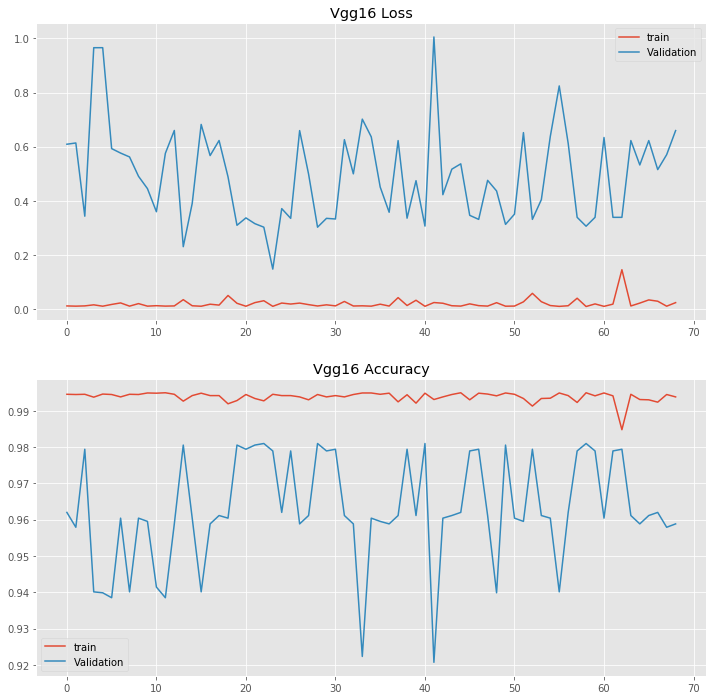

In [47]:
pyplot.figure(figsize=(12,12))
# plot loss during training
pyplot.subplot(211)
pyplot.title('Vgg16 Loss')
pyplot.plot(vgg16_history.history['loss'], label='train')
pyplot.plot(vgg16_history.history['val_loss'], label='Validation')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Vgg16 Accuracy')
pyplot.plot(vgg16_history.history['acc'], label='train')
pyplot.plot(vgg16_history.history['val_acc'], label='Validation')
pyplot.legend()
pyplot.show()

In [48]:
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.960, Test: 0.800


In [49]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predictions)
print('F1 score: %f' % f1)

Accuracy: 0.800000
Precision: 0.800000
Recall: 0.800000
F1 score: 0.800000


In [50]:
kappa = cohen_kappa_score(y_test, predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, predictions)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, predictions)
print(matrix)

Cohens kappa: 0.600000
ROC AUC: 0.800000
[[4 1]
 [1 4]]


In [0]:
history_1= vgg16_history

In [0]:
def ModelGraphTrainngSummary(history,N,model_name):
    # set the matplotlib backend so figures can be saved in the background
    # plot the training loss and accuracy
    import sys
    import matplotlib
    print("Generating plots...")
    sys.stdout.flush()
    matplotlib.use("Agg")
    matplotlib.pyplot.style.use("ggplot")
    matplotlib.pyplot.figure()
    matplotlib.pyplot.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    matplotlib.pyplot.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    #matplotlib.pyplot.plot(np.arange(0, N), history.history["acc"], label="train_acc")
    #matplotlib.pyplot.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
    matplotlib.pyplot.title("Training Loss and Accuracy on Brain Tumor Classification")
    matplotlib.pyplot.xlabel("Epoch #")
    matplotlib.pyplot.ylabel("Loss/Accuracy of "+model_name)
    matplotlib.pyplot.legend(loc="lower left")
    matplotlib.pyplot.savefig("plot.png")

In [0]:
def ModelGraphTrainngSummaryAcc(history,N,model_name):
    # set the matplotlib backend so figures can be saved in the background
    # plot the training loss and accuracy
    import sys
    import matplotlib
    print("Generating plots...")
    sys.stdout.flush()
    matplotlib.use("Agg")
    matplotlib.pyplot.style.use("ggplot")
    matplotlib.pyplot.figure()
    #matplotlib.pyplot.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    #matplotlib.pyplot.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    matplotlib.pyplot.plot(np.arange(0, N), history.history["acc"], label="train_acc")
    matplotlib.pyplot.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
    matplotlib.pyplot.title("Training Loss and Accuracy on Brain Tumor Classification")
    matplotlib.pyplot.xlabel("Epoch #")
    matplotlib.pyplot.ylabel("Accuracy of "+ model_name)
    matplotlib.pyplot.legend(loc="lower left")
    matplotlib.pyplot.savefig("plot.png")

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Generating plots...
Generating plots...
Val Accuracy = 0.96


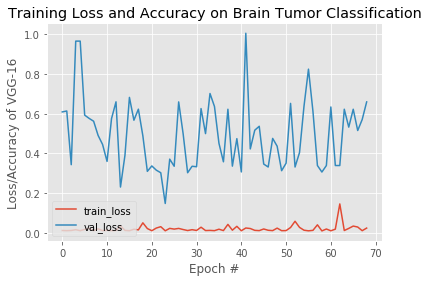

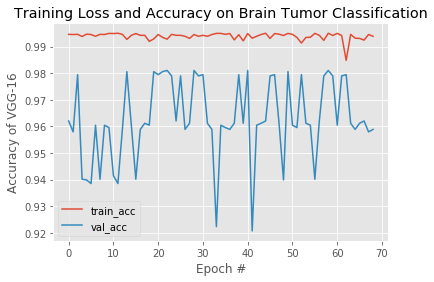

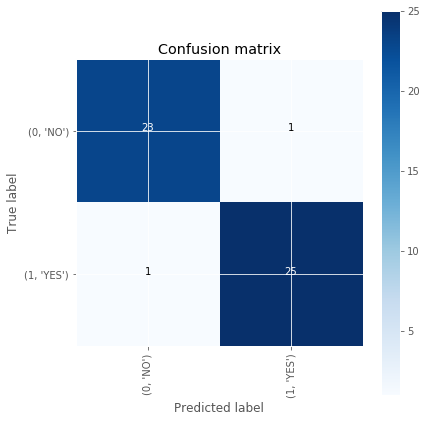

In [56]:
from sklearn.metrics import accuracy_score, confusion_matrix

for x_model in [{'name':'VGG-16','history':history_1,'model':model},]:
    ModelGraphTrainngSummary(x_model['history'],69,x_model['name'])
    ModelGraphTrainngSummaryAcc(x_model['history'],69,x_model['name'])
    
    # validate on val set
    predictions = x_model['model'].predict(X_val_prep)
    predictions = [1 if x>0.5 else 0 for x in predictions]

    accuracy = accuracy_score(y_val, predictions)
    print('Val Accuracy = %.2f' % accuracy)

    confusion_mtx = confusion_matrix(y_val, predictions) 
    cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [0]:
model.save('VGG16_Fine_Tune_69_epochs_1.h5')